# Построение рекомендательной системы книг на базе отзывов пользователей [BookCrossing](http://www.bookcrossing.com/)

<div class='alert alert-block alert-info'>
    <p><b>О наборе данных:</b> Отзывы пользователей сайта BookCrossing о книгах разных жанров.</p>
    <p>Содержит информацию о названих, авторах, и издателях, а также рейтинги пользователей по шкале от 1-го до 10-ти.</p>
    <p><a href='http://www2.informatik.uni-freiburg.de/~cziegler/BX/'>Источник.</a></p>
    <p><a href= 'http://www2.informatik.uni-freiburg.de/~cziegler/BX/WWW-2005-Preprint.pdf'>Improving Recommendation Lists Through Topic Diversification, Cai-Nicolas Ziegler, Sean M. McNee, Joseph A. Konstan, Georg Lausen; Proceedings of the 14th International World Wide Web Conference (WWW '05), May 10-14, 2005, Chiba, Japan.</a></p>
</div>

<div class='alert alert-block alert-warning'>
    <p><b>Цель: </b>разработка модели для рекоммендации книг на основе пользовательских предпочтений.</p>
    <p>Попутно будут построены оценки схожести изданй и пользователей для предсказания отсутсвующих значений рейтингов.</p>    
</div>

## 1. Анализ и подготовка данных

In [1]:
import path
import csv
import os

import pandas as pd
import numpy as np
import missingno as mno
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
raw_data_file_name = './data/BX-Book-Ratings.csv'

In [3]:
with open(raw_data_file_name, 'rt', encoding='iso-8859-1') as csv_file:
    reader = csv.DictReader(csv_file, delimiter=';', quoting=csv.QUOTE_ALL)
    print(reader.fieldnames)

['User-ID', 'ISBN', 'Book-Rating']


In [4]:
raw_ratings_table = {'user_id':[], 'book_id':[], 'rating':[]}
with open(raw_data_file_name, 'rt', encoding='iso-8859-1') as csv_file:
    reader = csv.DictReader(csv_file, delimiter=';', quoting=csv.QUOTE_ALL)
    for row in reader:
        user_id = row['User-ID']
        book_id = row['ISBN']
        rating = row['Book-Rating']
        raw_ratings_table['user_id'].append(user_id)
        raw_ratings_table['book_id'].append(book_id)
        raw_ratings_table['rating'].append(int(rating))

In [5]:
raw_ratings_df = pd.DataFrame(raw_ratings_table).drop_duplicates()
raw_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
user_id    1149780 non-null object
book_id    1149780 non-null object
rating     1149780 non-null int64
dtypes: int64(1), object(2)
memory usage: 35.1+ MB


In [6]:
user_info_file_name = './data/BX-Users.csv'

In [7]:
with open(user_info_file_name, 'rt', encoding='iso-8859-1') as csv_file:
    reader = csv.DictReader(csv_file, delimiter=';', quoting=csv.QUOTE_ALL)
    print(reader.fieldnames)

['User-ID', 'Location', 'Age']


In [8]:
user_info_table = {'user_id':[], 'location':[], 'age':[]}
with open(user_info_file_name, 'rt', encoding='iso-8859-1') as csv_file:
    reader = csv.DictReader(csv_file, delimiter=';', quoting=csv.QUOTE_ALL)
    for row in reader:
        user_id = row['User-ID']
        location = row['Location']
        age = int(row['Age']) if row['Age'].isdigit() else None
        
        user_info_table['user_id'].append(user_id)
        user_info_table['location'].append(location)
        user_info_table['age'].append(age)

In [9]:
user_info_df = pd.DataFrame(user_info_table).drop_duplicates()
user_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278858 entries, 0 to 278857
Data columns (total 3 columns):
user_id     278858 non-null object
location    278858 non-null object
age         168096 non-null float64
dtypes: float64(1), object(2)
memory usage: 8.5+ MB


#### Анализ информации о пользователях

In [10]:
user_info_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,278858,278858,82863,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,278858,57339,"london, england, united kingdom",2506,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,168096,NaN,NaN,NaN,34.7514,14.4281,0,24,32,44,244


In [11]:
user_info_df['location'].value_counts()[:20]

london, england, united kingdom        2506
toronto, ontario, canada               2250
sydney, new south wales, australia     1744
melbourne, victoria, australia         1708
portland, oregon, usa                  1629
chicago, illinois, usa                 1526
seattle, washington, usa               1484
new york, new york, usa                1411
madrid, madrid, spain                  1400
vancouver, british columbia, canada    1359
san diego, california, usa             1277
san francisco, california, usa         1269
ottawa, ontario, canada                1243
houston, texas, usa                    1187
berlin, berlin, germany                1173
milano, lombardia, italy               1157
los angeles, california, usa           1005
austin, texas, usa                      986
calgary, alberta, canada                981
barcelona, barcelona, spain             905
Name: location, dtype: int64

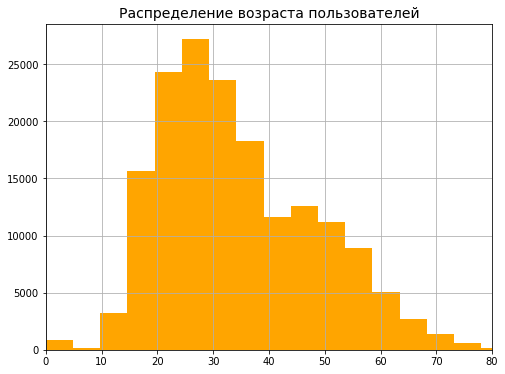

In [12]:
fig, ax = plt.subplots()
user_info_df['age'].hist(bins=50, color='orange', figsize=(8,6));
ax.set_xlim((0,80));
plt.title(label='Распределение возраста пользователей', fontsize=14);

In [13]:
user_info_df[user_info_df['location']=='london, england, united kingdom']['age'].describe()

count    1629.000000
mean       32.041743
std        11.351302
min         0.000000
25%        26.000000
50%        30.000000
75%        37.000000
max       141.000000
Name: age, dtype: float64

<div class='alert alert-block alert-info'>
    <p>Наши читатели, в основном - жители Австралии, Великобритании, США и Канады. Средний возраст - <b>35</b> лет.</p>
    <p>А самая многочисленная группа - жители <b>Лондона</b> со средним возрастом <b>32</b> года.</p>
</div>

#### Анализ информации о книгах.

In [14]:
book_info_file_name = './data/BX-Books.csv'

In [15]:
with open(book_info_file_name, 'rt', encoding='iso-8859-1') as csv_file:
    reader = csv.DictReader(csv_file, delimiter=';', quoting=csv.QUOTE_ALL)
    print(reader.fieldnames)

['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']


In [16]:
book_info_table = {'book_id':[], 'title':[], 'author':[], 'year':[], 'publisher':[]}
with open(book_info_file_name, 'rt', encoding='iso-8859-1') as csv_file:
    reader = csv.DictReader(csv_file, delimiter=';', quoting=csv.QUOTE_ALL)
    for row in reader:
        book_id = row['ISBN']
        title = row['Book-Title']
        author = row['Book-Author']
        year = int(row['Year-Of-Publication']) if row['Year-Of-Publication'].isdigit() else None
        publisher = row['Publisher']
        
        book_info_table['book_id'].append(book_id)
        book_info_table['title'].append(title)
        book_info_table['author'].append(author)
        book_info_table['year'].append(year)
        book_info_table['publisher'].append(publisher)

In [17]:
book_info_df = pd.DataFrame(book_info_table).drop_duplicates()
book_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271379 entries, 0 to 271378
Data columns (total 5 columns):
book_id      271379 non-null object
title        271379 non-null object
author       271379 non-null object
year         271357 non-null float64
publisher    271379 non-null object
dtypes: float64(1), object(4)
memory usage: 12.4+ MB


In [18]:
book_info_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
book_id,271379,271379,0671027301,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,271379,242154,Selected Poems,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
author,271379,102043,Agatha Christie,632,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,271357,NaN,NaN,NaN,1959.76,257.994,0,1989,1995,2000,2050
publisher,271379,16825,Harlequin,7535,NaN,NaN,NaN,NaN,NaN,NaN,NaN


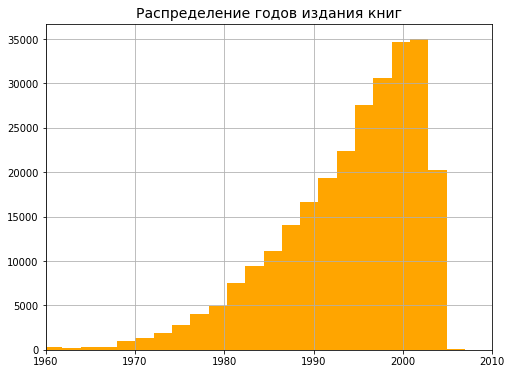

In [19]:
fig, ax = plt.subplots()
book_info_df['year'].hist(bins=1000, color='orange', figsize=(8,6));
ax.set_xlim((1960,2010));
plt.title(label='Распределение годов издания книг', fontsize=14);

In [20]:
book_info_df['author'].value_counts()[:10]

Agatha Christie        632
William Shakespeare    567
Stephen King           524
Ann M. Martin          423
Carolyn Keene          373
Francine Pascal        372
Isaac Asimov           330
Nora Roberts           315
Barbara Cartland       307
Charles Dickens        302
Name: author, dtype: int64

<div class='alert alert-block alert-info'>
    <p>В основном, собраны рейтинги художественных произведений.<b>35</b> лет.</p>
    <p>Самые упоминаемые авторы - <b>Агата Кристи, Шекспир и Стивен Кинг</b>.</p>
    <p>Набор данных был собран в 2005 году. Но интересно, что половина книг из рейтинга опубликованы до <b>1995</b> года.</p>
</div>

#### Анализ данных из таблицы рейтингов

In [21]:
raw_ratings_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,1149780,105283,11676,13602,NaN,NaN,NaN,NaN,NaN,NaN,NaN
book_id,1149780,340556,0971880107,2502,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,1.14978e+06,NaN,NaN,NaN,2.86695,3.85418,0,0,0,7,10


<div class='alert alert-block alert-warning'>
    <p>В данных встречаются <b>105000</b> уникальных имён пользователей и <b>340000</b> уникальных названий книг</p>    
</div>

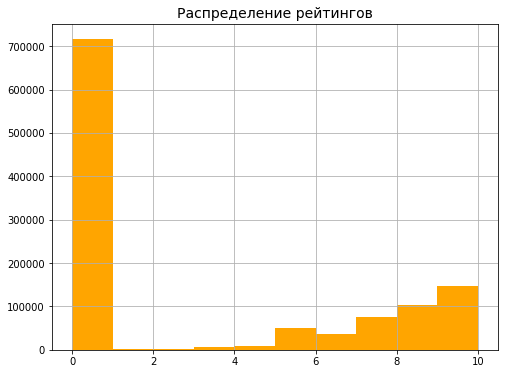

In [22]:
raw_ratings_df['rating'].hist(color='orange', figsize=(8,6));
plt.title(label='Распределение рейтингов', fontsize=14);

<div class='alert alert-block alert-warning'>
    <p>Абсолютное большинство</a> - <b>700000</b> - значений рейтинга имеет значение <b>0</b>.</p>    
    <p>Согласно описанию набора данных, это - т.н. <b>неявный негативный</b> рейтинг, т.е. отсутствия отзыва, просмотра, покупки и т.п., <b>отсутсвтие взаимодействия</b> пользователь-предмет.</p>    
    <p>Эти нулевые значения можно спрогнозировать.</p>
    <p>Значения <b>явного</b> рейтинга <a id='rating_distribution'>распределены</a> в диапазоне от 5-ти до 10-ти.</p>
</div>

In [23]:
user_summary = raw_ratings_df.groupby(by='user_id').count()
user_summary

,book_id,rating
user_id,,
10,2,2
100,1,1
1000,1,1
100001,1,1
100002,1,1
...,...,...
99992,1,1
99993,4,4
99996,44,44


In [24]:
user_summary.describe().T

,count,mean,std,min,25%,50%,75%,max
book_id,105283.0,10.920851,90.562825,1.0,1.0,1.0,4.0,13602.0
rating,105283.0,10.920851,90.562825,1.0,1.0,1.0,4.0,13602.0


<div class='alert alert-block alert-warning'>
    <p>Большинство пользователей сделали не более <b>4-ёх</b> оценок!</p>
    <p>При этом половина пользователей сделели по <b>1-ой</b> оценке.</p>    
    <p>Хотя среднее по пользователям количество оценок - <b>11</b>, при оценки похожести пользователей предлагается отбросить тех, которые сделали меньше, например, 10-ти или 20-ти оценок.</p>
    <p>Посмотрим, сколько пользователей отвечают этим условиям.</p>    
</div>

In [25]:
user_informativity = user_summary['rating'] > 20
user_summary[user_summary['rating'] > 20]

,book_id,rating
user_id,,
100009,42,42
10001,23,23
100088,140,140
100115,46,46
100119,22,22
...,...,...
99720,42,42
99738,48,48
99946,21,21


In [26]:
book_summary = raw_ratings_df.groupby(by='book_id').count()
book_summary

,user_id,rating
book_id,,
0330299891,2,2
0375404120,2,2
0586045007,1,1
9022906116,2,2
9032803328,1,1
...,...,...
cn113107,1,1
ooo7156103,1,1
§423350229,1,1


In [27]:
book_summary.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,340556.0,3.376185,12.436252,1.0,1.0,1.0,2.0,2502.0
rating,340556.0,3.376185,12.436252,1.0,1.0,1.0,2.0,2502.0


<div class='alert alert-block alert-warning'>
    <p>Большинство книг имеют не более <b>2-ух</b> оценок!</p>
    <p>При этом половина книг имеет только <b>1-у</b> оценку.</p>    
    <p>Среднее по всем книгам количество оценок - чуть более <b>3-ёх</b></p>
    <p>По аналогии с пользователями, при оценки похожести книг предлагается отбросить те, которые имеют меньше, 10-ти или 20-ти оценок</p>
</div>

In [28]:
book_informativity = book_summary['rating'] > 20
book_summary[book_summary['rating'] > 20]

,user_id,rating
book_id,,
0006493580,24,24
000649840X,89,89
0006512135,33,33
0006513204,23,23
0006514855,26,26
...,...,...
884590184X,34,34
8873122933,88,88
8885989403,23,23


In [29]:
informative_user_ids = [user_id for user_id in user_informativity.index.values if True==user_informativity[user_id]]

In [30]:
user_informative_df = raw_ratings_df[raw_ratings_df['user_id'].isin(informative_user_ids)]
user_informative_df

,user_id,book_id,rating
31,276762,034544003X,0
32,276762,0380000059,0
33,276762,0380711524,5
34,276762,0451167317,0
35,276762,0451454952,0
...,...,...,...
1149744,276688,0836236688,10
1149745,276688,0892966548,10
1149746,276688,1551669315,6
1149747,276688,1575660792,7


In [31]:
informative_book_ids = [book_id for book_id in book_informativity.index.values if True==book_informativity[book_id]]

In [32]:
book_informative_df = raw_ratings_df[raw_ratings_df['book_id'].isin(informative_book_ids)]
book_informative_df

,user_id,book_id,rating
0,276725,034545104X,0
2,276727,0446520802,0
8,276744,038550120X,7
10,276746,0425115801,0
11,276746,0449006522,0
...,...,...,...
1149768,276704,0446605409,0
1149771,276704,0743211383,7
1149772,276704,080410526X,0
1149776,276706,0679447156,0


In [33]:
informative_df = raw_ratings_df[(raw_ratings_df['user_id'].isin(informative_user_ids)) & (raw_ratings_df['book_id'].isin(informative_book_ids))]
informative_df

,user_id,book_id,rating
33,276762,0380711524,5
34,276762,0451167317,0
173,276847,0446364193,0
175,276847,3379015180,0
182,276847,3426029553,8
...,...,...,...
1149737,276688,0688143687,0
1149738,276688,0688156134,8
1149743,276688,0836218655,10
1149744,276688,0836236688,10


<div class='alert alert-blocl alert-success'>
    <p>Таким образом из более, чем миллиона исходных записей, информативными можно признать почти <b>283 тысячи</b>.</p>
    <p>Это - рейтинги тех пользователей, которые поставили не менее 20 оценок и тех книг, которые имеют не менее 20-ти оценок.</p>
</div>

#### Формируем матрицу взаимодействия "пользователь-книга": в каждой строке - рейтинги, выставленные пользователем, в каждом столбце - рейтинги, присвоенные книге.

In [34]:
user_book_nan = informative_df.pivot(index='user_id', columns='book_id', values='rating')
user_book_df = informative_df.pivot(index='user_id', columns='book_id', values='rating').fillna(0)
user_book_df

book_id,0006493580,000649840X,0006512135,0006513204,0006514855,0006547834,0006550576,0006550681,0006550789,0007108273,...,8817106100,8817106259,8817131628,8845205118,8845247414,884590184X,8873122933,8885989403,950491036X,9727722458
user_id,,,,,,,,,,,,,,,,,,,,,
100009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100088,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Вычисляем средние значения __ненулевых__ рейтингов для книг и пользователей.

In [35]:
user_book_nonzero_mean = user_book_df.sum(axis=1) / user_book_df.astype(bool).sum(axis=1)
user_book_nonzero_mean

user_id
100009     7.928571
10001     10.000000
100088     9.208333
100115     8.000000
100119     9.666667
            ...    
99720      8.700000
99738      8.200000
99946      6.333333
99955      7.192308
99996      7.785714
Length: 6876, dtype: float64

In [36]:
book_user_nonzero_mean = user_book_df.sum(axis=0) / user_book_df.astype(bool).sum(axis=0)
book_user_nonzero_mean

book_id
0006493580     7.750000
000649840X     7.250000
0006512135     5.000000
0006513204     7.555556
0006514855     7.625000
                ...    
884590184X    10.000000
8873122933     7.833333
8885989403     5.500000
950491036X     9.500000
9727722458     6.666667
Length: 7063, dtype: float64

#### 20 книг с самым высоким рейтингом.

In [37]:
top_rated_book_ids = book_user_nonzero_mean.sort_values(ascending=False).index[:20].tolist()

In [38]:
book_info_df[book_info_df['book_id'].isin(top_rated_book_ids)]

,book_id,title,author,year,publisher
1532,0486280616,Adventures of Huckleberry Finn (Dover Thrift E...,Mark Twain,1994.0,Dover Publications
5267,884590184X,Siddharta Romanzo Versione Di M Mila,Hermann Hesse,0.0,Adelphi Book Shop Ltd
5871,1888054557,Postmarked Yesteryear: 30 Rare Holiday Postcards,Pamela E. Apkarian-Russell,2001.0,Collectors Press
12079,0451175190,Reversible Error,Robert K. Tanenbaum,1994.0,Signet Book
12939,0380761327,Flowers from the Storm,Laura Kinsale,2003.0,Avon
23317,0385480334,Diary of a Young Girl: The Definitive Editon,Anne Frank,1996.0,Anchor
27868,0440173507,The Onion Field,JOSEPH WAMBAUGH,1987.0,Dell
28409,3453150538,Weit wie das Meer.,Nicholas Sparks,1999.0,Heyne
30129,0446605980,The Last Day,Glenn Kleier,1998.0,Warner Vision
31027,0440121353,Eden Burning,Belva Plain,1987.0,Dell


#### 20 пользователей, выставивших савмые высокие рейтинги.

In [39]:
top_rating_user_ids = user_book_nonzero_mean.sort_values(ascending=False).index[:20].tolist()

In [40]:
user_info_df[user_info_df['user_id'].isin(top_rating_user_ids)]

,user_id,location,age
14572,14573,"newburgh, new york, usa",19.0
54075,54076,"kitchener, ontario, canada",NaN
57411,57412,"porto, porto, portugal",25.0
57611,57612,"swansea, wales, united kingdom",34.0
89868,89869,"louisville, kentucky, usa",40.0
144584,144585,"ourense, ourense, spain",28.0
145727,145728,"woodside, california, usa",52.0
147413,147414,"central, wisconsin, usa",42.0
159039,159040,"federal way, washington, usa",14.0
198411,198412,"waretown, new jersey, usa",17.0


<div class='alert alert-block alert-warning'>Значения оценок смещаем так, чтобы средняя ПО НЕНУЛЕВЫМ значениям оценка каждого пользователя былы равна 0.</div>

In [41]:
biased_user_book_ratings = user_book_nan.copy(deep=True).replace(0, np.nan)
for col in biased_user_book_ratings.columns:
    biased_user_book_ratings[col] -= user_book_nonzero_mean

biased_user_book_ratings = biased_user_book_ratings.fillna(0)
biased_user_book_ratings

book_id,0006493580,000649840X,0006512135,0006513204,0006514855,0006547834,0006550576,0006550681,0006550789,0007108273,...,8817106100,8817106259,8817131628,8845205118,8845247414,884590184X,8873122933,8885989403,950491036X,9727722458
user_id,,,,,,,,,,,,,,,,,,,,,
100009,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10001,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100088,0.0,0.0,0.0,0.0,0.0,0.0,0.791667,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100115,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100119,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99720,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99738,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99946,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
biased_user_book_ratings.sum(axis=1) / biased_user_book_ratings.astype(bool).sum(axis=1)

user_id
100009   -2.537653e-16
10001              NaN
100088   -5.921189e-16
100115    0.000000e+00
100119    5.921189e-16
              ...     
99720     7.105427e-16
99738     7.105427e-16
99946     2.960595e-16
99955    -2.391250e-16
99996     1.268826e-16
Length: 6876, dtype: float64

## 2. Оценка похожести читателей и похожести книг

In [43]:
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

#### Для вычисления меры похожести преобразуем таблицу рейтингов в матрицу разреженных строк.

In [44]:
user_book_matrix = sparse.csr_matrix(biased_user_book_ratings.values)

In [45]:
user_similarity_matrix = cosine_similarity(user_book_matrix, user_book_matrix)

In [46]:
user_similarity_matrix.shape

(6876, 6876)

In [47]:
user_stop_list = set()
for i in range(len(user_similarity_matrix)):
    user_similarity_matrix[i,i] = 1
    for j in range(i):
        if user_similarity_matrix[i,j] > 0.8 and j not in user_stop_list:
            user_stop_list.add(j)

In [48]:
len(user_stop_list)

22

In [49]:
book_user_matrix = sparse.csr_matrix(biased_user_book_ratings.T.values)

In [50]:
book_similarity_matrix = cosine_similarity(book_user_matrix, book_user_matrix)

In [51]:
book_stop_list = set()
for i in range(len(book_similarity_matrix)):
    book_similarity_matrix[i,i] = 1
    for j in range(i):
        if book_similarity_matrix[i,j] > 0.8 and j not in book_stop_list:
            book_stop_list.add(j)    

In [52]:
len(book_stop_list)

255

<div class='alert alert-block alert-warning'>
    <p>В наборе данных обнаружены <b>22 пары пользователей</b> и <b>255 пар книг</b>, имеющих значение косинусной близости более 0.8</p>
    <p>Отбросим соответствующие записи и повторим вычисление матриц похожести.</p>
</div>    

In [53]:
user_id_list = biased_user_book_ratings.index.values

In [54]:
book_id_list = biased_user_book_ratings.columns

#### Составляем списки id слишком близких книг и пользователей по их индексам в матрицах близости.

In [55]:
duplicate_user_ids = []
for i in user_stop_list:
    duplicate_user_ids.append(user_id_list[i])

In [56]:
duplicate_book_ids = []
for i in book_stop_list:
    duplicate_book_ids.append(book_id_list[i])

#### Удаляем соответствующие записи из списка рейтингов

In [57]:
informative_df = informative_df[informative_df['user_id'].isin(duplicate_user_ids)==False]
informative_df = informative_df[informative_df['book_id'].isin(duplicate_book_ids)==False]
informative_df

,user_id,book_id,rating
33,276762,0380711524,5
34,276762,0451167317,0
173,276847,0446364193,0
175,276847,3379015180,0
182,276847,3426029553,8
...,...,...,...
1149737,276688,0688143687,0
1149738,276688,0688156134,8
1149743,276688,0836218655,10
1149744,276688,0836236688,10


#### Заново формируем матрицу взаимодействия.

In [58]:
user_book_nan = informative_df.pivot(index='user_id', columns='book_id', values='rating')
user_book_df = informative_df.pivot(index='user_id', columns='book_id', values='rating').fillna(0)

user_book_nonzero_mean = user_book_df.sum(axis=1) / user_book_df.astype(bool).sum(axis=1)

biased_user_book_ratings = user_book_nan.copy(deep=True).replace(0, np.nan)
for col in biased_user_book_ratings.columns:
    biased_user_book_ratings[col] -= user_book_nonzero_mean

biased_user_book_ratings = biased_user_book_ratings.fillna(0)
biased_user_book_ratings

book_id,0006493580,000649840X,0006512135,0006513204,0006514855,0006547834,0006550576,0006550681,0006550789,0007108273,...,8817106100,8817106259,8817131628,8845205118,8845247414,884590184X,8873122933,8885989403,950491036X,9727722458
user_id,,,,,,,,,,,,,,,,,,,,,
100009,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10001,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100088,0.0,0.0,0.0,0.0,0.0,0.0,0.791667,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100115,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100119,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99720,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99738,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99946,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
user_id_list = biased_user_book_ratings.index.values

In [60]:
book_id_list = biased_user_book_ratings.columns

#### Вычисляем матрицы близости и убеждаемся, что слишком похожих компонентов стало намного меньше.

In [61]:
user_book_matrix = sparse.csr_matrix(biased_user_book_ratings.values)
user_similarity_matrix = cosine_similarity(user_book_matrix, user_book_matrix)

In [62]:
user_stop_list = set()
for i in range(len(user_similarity_matrix)):
    user_similarity_matrix[i,i] = 1
    for j in range(i):
        if user_similarity_matrix[i,j] > 0.8 and j not in user_stop_list:
            user_stop_list.add(j)
len(user_stop_list)

0

In [63]:
book_user_matrix = sparse.csr_matrix(biased_user_book_ratings.T.values)
book_similarity_matrix = cosine_similarity(book_user_matrix, book_user_matrix)

In [64]:
book_stop_list = set()
for i in range(len(book_similarity_matrix)):
    book_similarity_matrix[i,i] = 1
    for j in range(i):
        if book_similarity_matrix[i,j] > 0.8 and j not in book_stop_list:
            book_stop_list.add(j)
len(book_stop_list)

14

In [65]:
top_n_similar = 100

In [66]:
user_top_similarities = []
for row_index, row in enumerate(user_similarity_matrix):
    row_sum = row.sum() - 1
    if np.count_nonzero(row)==0:
        print(row_index, row)
    row_avg = 0 if row_sum==0 else row_sum / np.count_nonzero(row)
    user_top_similarities.append((row_index, row_avg))
user_top_similarities.sort(key=(lambda x: x[1]), reverse=True)
user_top_similarities = user_top_similarities[:top_n_similar]

In [67]:
similar_user_indices = [idx for idx,_ in user_top_similarities]

In [68]:
user_top_similarity_matrix = []
for row_index in similar_user_indices:
    row = []
    for column_index in similar_user_indices:
        row.append(user_similarity_matrix[row_index, column_index])
    user_top_similarity_matrix.append(row)

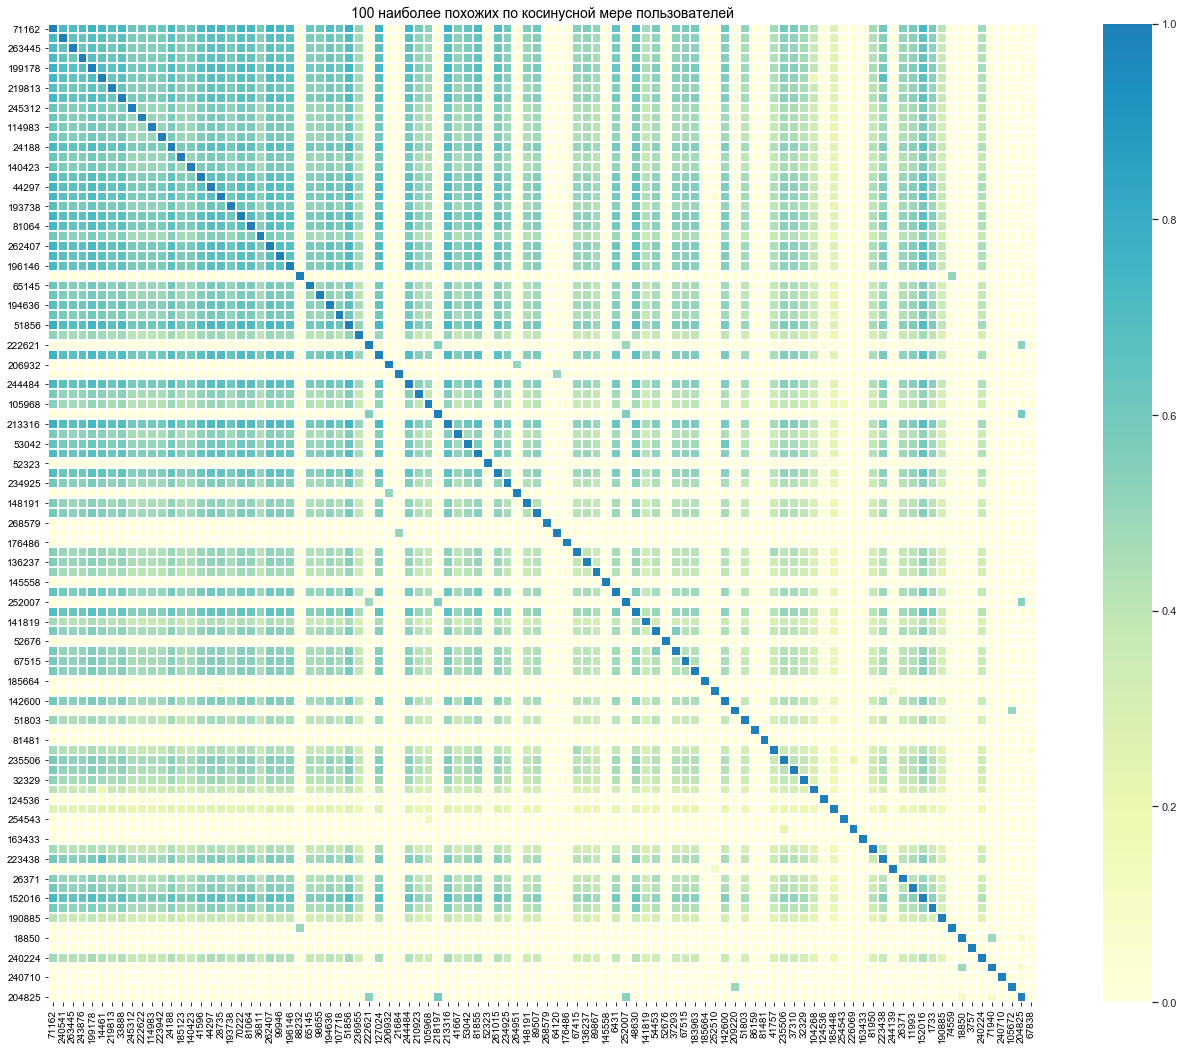

In [69]:
user_top_similarity_df = pd.DataFrame(data=user_top_similarity_matrix, columns=[user_id_list[i] for i in similar_user_indices], index=[user_id_list[i] for i in similar_user_indices])
fig, ax = plt.subplots(figsize=(24,18))
sns.set()
sns.heatmap(user_top_similarity_df, ax=ax, center=0.75, square=True, cmap='YlGnBu', linewidths=1, annot=False, fmt='0.1f', cbar=True)
  
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('100 наиболее похожих по косинусной мере пользователей', fontsize=14)

plt.show()

In [70]:
top_n_similar = 100

In [71]:
book_top_similarities = []
for row_index, row in enumerate(book_similarity_matrix):
    row_sum = row.sum() - 1
    if np.count_nonzero(row)==0:
        print(row_index, row)
    row_avg = 0 if row_sum==0 else row_sum / np.count_nonzero(row)
    book_top_similarities.append((row_index, row_avg))
book_top_similarities.sort(key=(lambda x: x[1]), reverse=True)
book_top_similarities = book_top_similarities[:top_n_similar]

In [72]:
similar_book_indices = [idx for idx,_ in book_top_similarities]

In [73]:
book_top_similarity_matrix = []
for row_index in similar_book_indices:
    row = []
    for column_index in similar_book_indices:
        row.append(book_similarity_matrix[row_index, column_index])
    book_top_similarity_matrix.append(row)

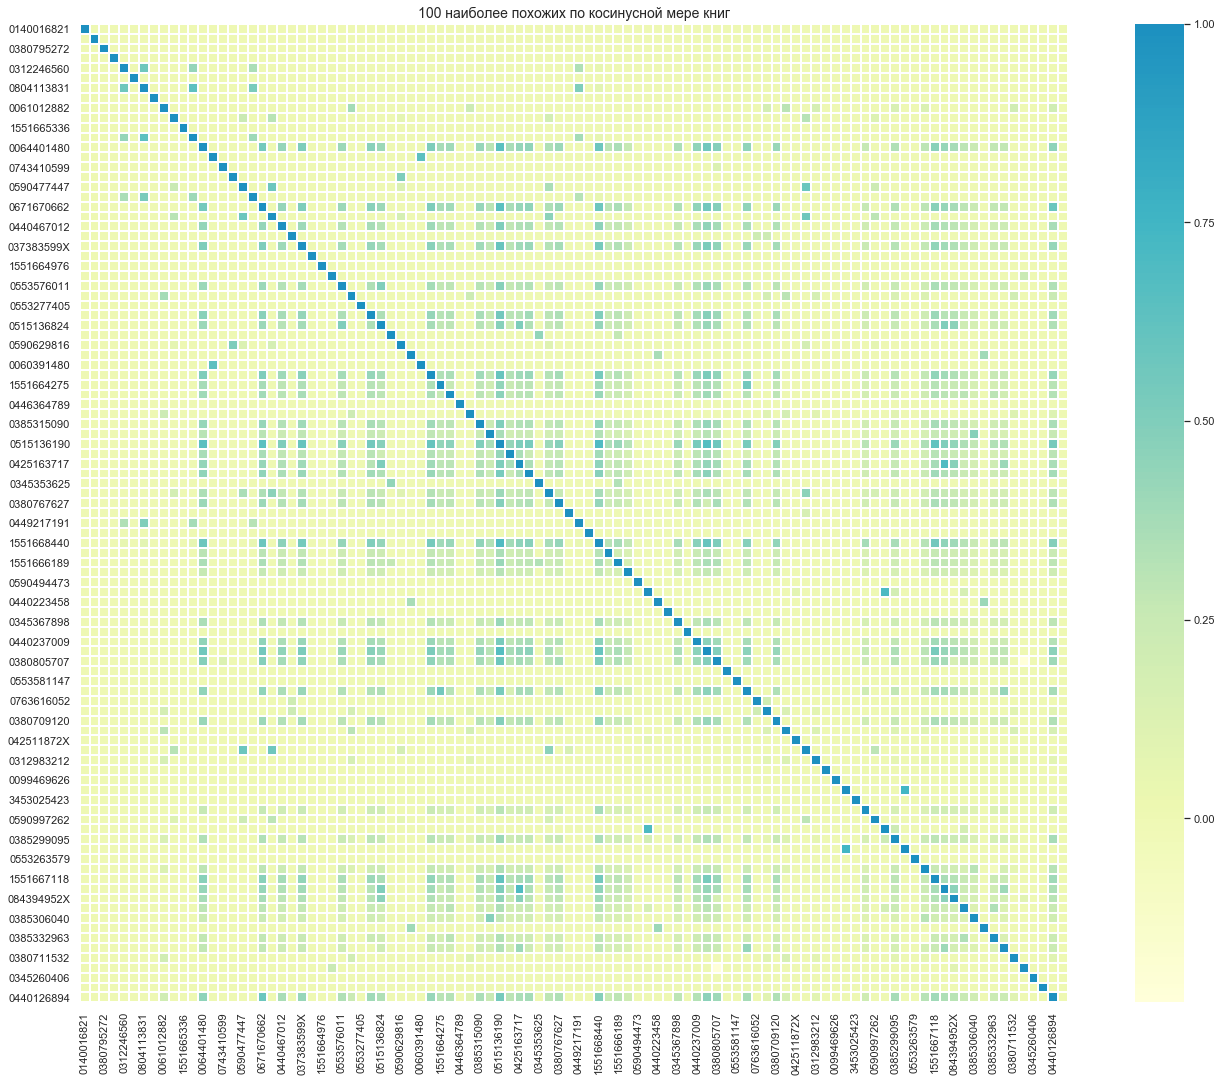

In [74]:
book_top_similarity_df = pd.DataFrame(data=book_top_similarity_matrix, columns=[book_id_list[i] for i in similar_book_indices], index=[book_id_list[i] for i in similar_book_indices])
fig, ax = plt.subplots(figsize=(24,18))
sns.set()
sns.heatmap(book_top_similarity_df, ax=ax, center=0.75, square=True, cmap='YlGnBu', linewidths=1, annot=False, fmt='0.1f', cbar=True)
  
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('100 наиболее похожих по косинусной мере книг', fontsize=14)

plt.show()

<div class='alert alert-block alert-info'>
    <p>Можно сделать <a id='similarity_comparison'><b>вывод</b></a>, что наиболее близкие по предпочтениям пользователи похожи в большей мере, чем близкие по оценкам книги.</p>
    <p>Это означает, что многие люди, оставившие отзывы и оценки, обладают схожими интересами, возможно схожими профессиями.</p>
    <p>При этом разнообразие тем книг намного больше разнообразия интересов пользователей.</p>
</div>

## 3. Предсказание отсутствующих рейтингов с использованием библиотеки surprise

In [75]:
from surprise import Dataset, Reader
from surprise import BaselineOnly, KNNBasic, SVD
from surprise import accuracy
from surprise.model_selection import KFold, cross_validate, train_test_split

#### Преоразование набора данных в формат surpise.
#### DataFrame 'informative_df'  - данные в формате pandas, содержащие рейтнги книг и пользователей с числом отзывов более 10-ти.

In [76]:
surprise_data = Dataset.load_from_df(informative_df, Reader(rating_scale=(1,10)))

#### Обучение базовой модели, использующей предсказания на основе средних по пользователям и предметам рейтингов.

In [77]:
baseline_options = {'method' : 'sgd', 'n_epochs' : 20, 'reg_i' : 10, 'reg_u' : 15}

In [78]:
baseline_model = BaselineOnly(bsl_options=baseline_options, verbose=True)

In [79]:
train_data, test_data = train_test_split(data=surprise_data, test_size=0.3, random_state=1812, shuffle=True)

In [80]:
import pickle

In [81]:
# ДЛИТЕЛЬНЫЕ ВЫЧИСЛЕНИЯ! ДЛЯ ДЕМОНСТРАЦИИ РЕЗУЛЬТАТ ЗАГРУЖАЕТСЯ ИЗ ФАЙЛА
#base_cv_results = cross_validate(algo=baseline_model, data=surprise_data, cv=5, n_jobs=7)
#pickle.dump(base_cv_results, open('base_cv_results', 'wb'))
base_cv_results = pickle.load(open('base_cv_results', 'rb'))

In [82]:
pd.DataFrame(base_cv_results)

,test_rmse,test_mae,fit_time,test_time
0,3.391350,2.821429,0.569210,0.366132
1,3.410961,2.833620,0.557205,0.373136
2,3.398857,2.825597,0.550202,0.373138
3,3.388117,2.818959,0.555205,0.370135
4,3.399825,2.824487,0.553204,0.356130


#### Обучение модели, использующей алгоритм KNN и её сравнение с базовой моделью.

In [83]:
user_similarity_options = {
    'name' : 'cosine', # косинусная мера близости
    'user_based' : True, # обучение с учётом близости ПОЛЬЗОВАТЕЛЕЙ
    'min_support' : 5 # минимальное количество общих КНИГ, по которым оставлен отзыв
}

In [84]:
knn_user_model = KNNBasic(sim_options=user_similarity_options, k=20, min_k=2)

In [85]:
#knn_user_cv_results = cross_validate(algo=knn_user_model, data=surprise_data, cv=5, n_jobs=7)
#pickle.dump(knn_user_cv_results, open('knn_user_cv_results', 'wb'))
knn_user_cv_results = pickle.load(open('knn_user_cv_results', 'rb'))

In [86]:
pd.DataFrame(knn_user_cv_results)

,test_rmse,test_mae,fit_time,test_time
0,3.934963,3.411046,4.565673,3.968454
1,3.916170,3.392208,4.505651,4.163526
2,3.921414,3.393634,4.598686,4.028476
3,3.923569,3.394719,4.444630,3.958450
4,3.927493,3.400897,4.394610,3.880424


In [87]:
item_similarity_options = {
    'name' : 'cosine', # косинусная мера близости
    'user_based' : False, # обучение с учётом близости КНИГ
    'min_support' : 5 # минимальное количество общих ПОЛЬЗОВАТЕЛЕЙ, которые оставили отзыв
}

In [88]:
knn_item_model = KNNBasic(sim_options=item_similarity_options, k=20, min_k=2)

In [89]:
#knn_item_cv_results = cross_validate(algo=knn_item_model, data=surprise_data, cv=5, n_jobs=7)
#pickle.dump(knn_item_cv_results, open('knn_item_cv_results', 'wb'))
knn_item_cv_results = pickle.load(open('knn_item_cv_results', 'rb'))

In [90]:
pd.DataFrame(knn_item_cv_results)

,test_rmse,test_mae,fit_time,test_time
0,3.622536,3.007991,8.493112,8.488112
1,3.614987,3.000221,8.810228,8.548135
2,3.600081,2.988158,8.989294,7.986928
3,3.622092,3.006259,8.929273,7.754843
4,3.621231,3.009976,8.709193,7.647804


<div class='alert alert-block alert-info'>
    <p>Предсказание по похожим пользователям оказалось менее точным, чем предсказание по похожим книгам.</p>
    <p>Эти результаты согласуются с <a href='#similarity_comparison'><b>выводом</b></a> о том, что похожих пользователей больше, чем похожих книг, т.е. в рейтингах книг содержится больше информации.</p>    
    <p>Модель <b>KNN</b> показала результаты, <b>худшие</b>, чем у базовой модели.</p>
</div>

#### Обучение модели, основанной на разложении матрицы на множители SVD.

In [91]:
svd_model = SVD(n_factors=200, n_epochs=20, random_state=1812)

In [92]:
#svd_cv_results = cross_validate(algo=svd_model, data=surprise_data, cv=5, n_jobs=7, verbose=True)
#pickle.dump(svd_cv_results, open('svd_cv_results', 'wb'))
svd_cv_results = pickle.load(open('svd_cv_results', 'rb'))

In [93]:
pd.DataFrame(svd_cv_results)

,test_rmse,test_mae,fit_time,test_time
0,3.493946,2.909416,30.076023,0.730266
1,3.499156,2.914716,29.555831,0.614226
2,3.506885,2.918524,29.521819,0.601220
3,3.487868,2.902702,29.287734,0.634232
4,3.512218,2.919885,28.956611,0.631231


<div class='alert alert-block alert-info'>
    <p>Модель <b>SVD</b> показала результаты, <b>чуть хуже</b>, чем у базовой модели.</p>
</div>

In [94]:
informative_df['rating'].max()

10

In [95]:
informative_df['rating'].mean()

2.5395786289155233

<div class='alert alert-block alert-warning'>
    <p>Средняя абсолютная ошибка (MAE) предсказания рейтинга примерно равна <b>половине</b> значимого диапазона!</p>
    <p>Большинство оценок <a href='#rating_distribution'>распределены</a> в диапазон <b>от 5-ти до 10-ти</b>.</p>
</div>

#### Оценим качество рекоммендации модели SVD по предсказанным рейтингам.

In [96]:
surprise_trainset, surprise_testset = train_test_split(surprise_data, test_size=.3)

In [97]:
surprise_train_df = pd.DataFrame(data=surprise_trainset.build_testset(), columns = ['user_id', 'book_id', 'rating']).pivot(index='user_id', columns='book_id').fillna(0)

In [98]:
svd_model.fit(surprise_trainset)

In [99]:
surprise_predictions = svd_model.test(surprise_testset)

In [100]:
accuracy.mae(surprise_predictions)

MAE:  2.9306


2.930631026517795

Преобразуем предсказанные рейтинги в таблицу, сгруппировав ошибки предсказания по пользователям

In [101]:
surprise_predictions_table = {}
max_item_count = 0
for idx, prediction in enumerate(surprise_predictions):
    uid = prediction.uid
    error = np.abs(prediction.est - prediction.r_ui)
    if uid in surprise_predictions_table:
        surprise_predictions_table[uid].append(error)
        if len(surprise_predictions_table[uid]) > max_item_count:
            max_item_count = len(surprise_predictions_table[uid])
    else:
        surprise_predictions_table[uid] = [error]        

# приводим списки ошибок всех пользователей к одной длине
for uid in surprise_predictions_table:
    err_list = surprise_predictions_table[uid]
    if len(err_list) < max_item_count:
        padded_list = [np.nan] * max_item_count
        for idx, item in enumerate(err_list):
            padded_list[idx] = item
        surprise_predictions_table[uid] = padded_list

In [102]:
max_item_count

956

In [103]:
surprise_predictions_df = pd.DataFrame.from_dict(surprise_predictions_table, orient='index')

In [104]:
surprise_predictions_df

,0,1,2,3,4,5,6,7,8,9,...,946,947,948,949,950,951,952,953,954,955
150561,1.186583,3.818795,4.823276,7.407629,5.668092,3.603657,3.240505,5.811748,5.726477,2.334501,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87746,1.000000,1.000000,1.152373,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247055,7.000000,2.455385,1.000000,2.114108,5.240648,3.406305,1.878853,3.364972,3.708406,3.670526,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230522,1.559637,1.299024,1.000000,1.358732,4.672402,1.000000,1.000000,1.000000,1.000000,6.262880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170184,1.000000,1.641977,1.000000,1.000000,1.000000,1.000000,2.385352,4.189443,1.057172,1.032348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134621,5.319689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238630,6.852702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22409,5.162303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22648,2.896804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
surprise_predictions_df['count'] = surprise_predictions_df.count(axis=1)
surprise_predictions_df['sum_abs'] = surprise_predictions_df.sum(axis=1)
surprise_predictions_df['sum_sqr'] = surprise_predictions_df['sum_abs'].apply(np.square)

In [106]:
surprise_predictions_df = surprise_predictions_df.drop(columns=range(max_item_count))

In [107]:
surprise_predictions_df['mae'] = surprise_predictions_df['sum_abs'] / surprise_predictions_df['count']
surprise_predictions_df['mse'] = surprise_predictions_df['sum_sqr'] / surprise_predictions_df['count']
surprise_predictions_df

,count,sum_abs,sum_sqr,mae,mse
150561,24,113.394519,12858.316878,4.724772,535.763203
87746,99,202.088713,40839.848032,2.041300,412.523717
247055,18,73.269716,5368.451274,4.070540,298.247293
230522,217,659.662153,435154.155768,3.039918,2005.318690
170184,34,102.114835,10427.439565,3.003378,306.689399
...,...,...,...,...,...
134621,1,6.319689,39.938474,6.319689,39.938474
238630,1,7.852702,61.664931,7.852702,61.664931
22409,1,6.162303,37.973980,6.162303,37.973980
22648,1,3.896804,15.185085,3.896804,15.185085


<div class='alert alert-block alert-warning'>
    <p>Теперь у нас есть список пользователей, отсортированных по точности рпедсказанных рейтингов.</p>    
</div>

In [108]:
sorted_surprise_predictions_df = surprise_predictions_df.sort_values(by='mae')
sorted_surprise_predictions_df[:10].style.highlight_max(subset=['count'], color='orange')

,count,sum_abs,sum_sqr,mae,mse
135170,1,1.02822,1.05723,1.02822,1.05723
212411,1,1.07237,1.14997,1.07237,1.14997
193746,1,1.12513,1.26593,1.12513,1.26593
28537,1,1.15694,1.33851,1.15694,1.33851
93141,1,1.27743,1.63183,1.27743,1.63183
140822,1,1.28151,1.64228,1.28151,1.64228
121667,1,1.28839,1.65995,1.28839,1.65995
140358,38,55.007,3025.77,1.44755,79.6255
67402,1,1.44848,2.09809,1.44848,2.09809
22813,1,1.44999,2.10246,1.44999,2.10246


In [109]:
surprise_test_df = pd.DataFrame(data=surprise_testset, columns = ['user_id', 'book_id', 'rating']).pivot(index='user_id', columns='book_id').fillna(0)

#### Предпотчения конкретного пользователя из тренировочного набора:

In [160]:
selected_user_id = '140358'

In [161]:
user_train_ratings_series = surprise_train_df.sort_values(by=selected_user_id, axis=1, ascending=False).loc[selected_user_id][:5]
user_train_ratings = [id for _,id in user_train_ratings_series.index.to_list()]

In [162]:
book_info_df[book_info_df['book_id'].isin(user_train_ratings)]

,book_id,title,author,year,publisher
1656,0345367898,Witching Hour (Lives of the Mayfair Witches),Anne Rice,1991.0,Ballantine Books
4131,0316666009,1st to Die: A Novel,James Patterson,2001.0,Little Brown and Company
8370,0385323921,The Klone and I: A High-Tech Love Story,Danielle Steel,1998.0,Delacorte Press
19835,0449910571,Ladder of Years,Anne Tyler,1996.0,Ballantine Books


#### Предпотчения этого же пользователя из тестового набора:

In [163]:
user_test_ratings_series = surprise_test_df.sort_values(by=selected_user_id, axis=1, ascending=False).loc[selected_user_id][:5]
user_test_ratings = [id for _,id in user_test_ratings_series.index.to_list()]

In [164]:
book_info_df[book_info_df['book_id'].isin(user_test_ratings)]

,book_id,title,author,year,publisher
5786,0425154092,From Potter's Field,Patricia Daniels Cornwell,1996.0,Berkley Publishing Group
8144,0375506039,Open House,Elizabeth Berg,2000.0,Random House Trade
9295,038550120X,A Painted House,JOHN GRISHAM,2001.0,Doubleday
22570,0842329285,The Indwelling: The Beast Takes Possession (Le...,Tim Lahaye,2000.0,Tyndale House Publishers
34477,0449005828,Bedford Square (Charlotte &amp; Thomas Pitt No...,Anne Perry,2000.0,Ballantine Books


In [165]:
surprise_test_df = pd.DataFrame(data=surprise_testset, columns = ['user_id', 'book_id', 'rating']).pivot(index='user_id', columns='book_id').fillna(0)

In [166]:
user_raw_ids = informative_df['user_id'].unique()
book_raw_ids = informative_df['book_id'].unique()

In [167]:
def get_surprise_user_recommendations(model, surprise_data, user_id, item_id_list, n_items=5):
    df_columns = surprise_data.df.columns
    user_col_name = df_columns[0]
    item_col_name = df_columns[1]
    rating_col_name = df_columns[2]
    exisitng_item_ratings = surprise_data.df[surprise_data.df[user_col_name] == user_id][[item_col_name, rating_col_name]].sort_values(by=rating_col_name, ascending=False).values.tolist()
    known_items = {key:value for key,value in exisitng_item_ratings[:n_items]}
    
    predicted_item_ratings = []
    for item_id in item_id_list:
        rating = model.predict(uid=user_id, iid=item_id).est
        predicted_item_ratings.append((item_id, rating))
    predicted_item_ratings.sort(key=(lambda x: x[1]), reverse=True)
    predicted_items = {key:value for key,value in predicted_item_ratings[:n_items]}
    
    return known_items, predicted_items

#### Определяем топ 15 известных и предсказанных рейтингов для нашего пользователя

In [168]:
known_items, predicted_items = get_surprise_user_recommendations(svd_model, surprise_data, user_id=selected_user_id, item_id_list=book_raw_ids, n_items=15)

#### Выбираем из предсказанных те, которые пользователь ещё не оценил...

In [169]:
recommended_ratings = []
for item_id in predicted_items.keys():
    if item_id not in known_items:
        recommended_ratings.append(item_id)

In [170]:
book_info_df[book_info_df['book_id'].isin(recommended_ratings)]

,book_id,title,author,year,publisher
37,0446310786,To Kill a Mockingbird,Harper Lee,1988.0,Little Brown &amp; Company
388,0156528207,The Little Prince,Antoine de Saint-ExupÃ©ry,1968.0,Harcourt
1101,0060256672,Where the Sidewalk Ends : Poems and Drawings,Shel Silverstein,1974.0,HarperCollins
1312,0553296981,Anne Frank: The Diary of a Young Girl,ANNE FRANK,1993.0,Bantam
1645,0553283685,Hyperion,DAN SIMMONS,1990.0,Bantam
3623,0811802981,The Golden Mean: In Which the Extraordinary Co...,Nick Bantock,1993.0,Chronicle Books
3839,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999.0,Scholastic
4764,006000438X,The Death of Vishnu: A Novel,Manil Suri,2002.0,Perennial
5432,0439064864,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,1999.0,Scholastic
6908,0894808249,All I Need to Know I Learned from My Cat,Suzy Becker,1990.0,Workman Publishing


## 4. Предсказание отсутствующих НЕЯВНЫХ рейтингов с использованием библиотеки lightfm

#### Подготовка матрицы взаимодействия

In [121]:
user_idx_to_id_dict = {key : value for key, value in enumerate(informative_df['user_id'].unique())}
user_id_to_idx_dict = {value : key for key, value in enumerate(informative_df['user_id'].unique())}
len(user_idx_to_id_dict)

6845

In [122]:
user_id_indices = [user_id_to_idx_dict[u_id] for u_id in informative_df['user_id'].values]

In [123]:
book_idx_to_id_dict = {key : value for key, value in enumerate(informative_df['book_id'].unique())}
book_id_to_idx_dict = {value : key for key, value in enumerate(informative_df['book_id'].unique())}
len(book_id_to_idx_dict)

6808

In [124]:
book_id_indices = [book_id_to_idx_dict[b_id] for b_id in informative_df['book_id'].values]

In [125]:
lightfm_data = sparse.csr_matrix((informative_df['rating'].values, (user_id_indices, book_id_indices)), shape=(len(user_id_list), len(book_id_list)))

In [126]:
lightfm_data.shape

(6845, 6808)

<div class='alert alert-block alert-warning'>
    <p>Наc интересует <b>неявный</b> рейтинг, т.е. наличие/отсутствие взаимодействия</p>
    <p>Поэтому наличие/отсутсвие <b>явного</b> численного рейтинга преобразуем в неявный</p>
</div>

In [127]:
lightfm_data[lightfm_data > 0] = 1
print(lightfm_data.A)

[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [128]:
from lightfm import cross_validation, LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

C:\Users\Supervisor\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [129]:
import random

In [130]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [131]:
def lightfm_train_test_split(interaction_matrix, test_percentage=0.2, random_state=None):
    train_matrix, test_matrix = cross_validation.random_train_test_split(
        interaction_matrix,
        test_percentage=test_percentage,
        random_state=np.random.seed(random_state)
    ) # делим исходную матрицу на тренировочную и тестовую
    nonzero_test_index_lists = test_matrix.nonzero() # получаем индексы ненулевых документов в виде кортежа списков
    nonzero_test_indices = list(zip(nonzero_test_index_lists[0], nonzero_test_index_lists[1])) # преобразуем кортеж списков в спиок кортежей
    test_user_indices = []
    test_item_indices = []    
    for user_idx, item_idx in nonzero_test_indices:
        test_user_indices.append(user_idx) # индексы пользователей для тестового набора
        test_item_indices.append(item_idx) # индексы предметов для тестового набора
    
    return train_matrix, test_matrix, np.array(test_user_indices, dtype='int32'), np.array(test_item_indices, dtype='int32')

#### Подбор параметров модели через максимизацию AUC score.

In [132]:
#metrics_grid = {}
#for no_components in [10, 50, 100, 200, 400]:
#    key = f'{no_components}_cmps'
#    metrics_grid[key] = []
#    for epochs in [5, 10, 20]:
#        # получаем тренировочную матрицу и индексы тестовой выборки
#        train_data, test_data, test_user_ids, test_item_ids = lightfm_train_test_split(lightfm_data, test_percentage=0.2, random_state=1812+no_components*epochs)
#        lightfm_basic_model = LightFM(no_components=no_components, loss='warp')
#        # обучаем модель
#        print(f'no_components:{no_components}, epochs:{epochs}: обучение', end=', ')
#        lightfm_basic_model.fit(train_data, epochs=epochs, num_threads=7, verbose=False)
#        print('оценка метрик:', end=' ')
#        # вычисляем метрики качества предсказания    
#        auc = auc_score(lightfm_basic_model, test_data)
#        print(auc.mean(), end=', ')
#        print('сохранение результатов.')        
#        metrics_grid[key].append(auc.mean())

In [133]:
#column_names = [f'{epochs}_epochs' for epochs in [5, 10, 20]]
#metrics_grid_df = pd.DataFrame.from_dict(metrics_grid, orient='index', columns=column_names)

In [134]:
#metrics_grid_df.to_pickle('lightfm_grid_results.pkl')
metrics_grid_df = pd.read_pickle('lightfm_grid_results.pkl')
metrics_grid_df.style.highlight_max(axis=None, color='orange')

,5_epochs,10_epochs,20_epochs
10_cmps,0.683269,0.704134,0.713818
50_cmps,0.715445,0.725969,0.725634
100_cmps,0.718393,0.725588,0.718596
200_cmps,0.715574,0.713241,0.714746
400_cmps,0.713406,0.71361,0.714118


#### Значение по умолчанию $epochs=10$ даёт лучшие результаты. Уточним оптимальное количество компонентов разложения.

In [135]:
#auc_values = {}
#no_components_grid = {}
#for no_components in [30, 40, 50, 60, 70, 80, 90]:    
#        # получаем тренировочную матрицу и индексы тестовой выборки
#        train_data, test_data, test_user_ids, test_item_ids = lightfm_train_test_split(lightfm_data, test_percentage=0.2, random_state=1812+no_components)
#        lightfm_basic_model = LightFM(no_components=no_components, loss='warp')
#        # обучаем модель
#        print(f'no_components: {no_components} обучение', end=', ')
#        lightfm_basic_model.fit(train_data, epochs=10, num_threads=7, verbose=False)
#        print('оценка метрик:', end=' ')
#        # вычисляем метрики качества предсказания    
#        auc = auc_score(lightfm_basic_model, test_data)
#        print(auc.mean(), '.')
#        key = f'{no_components}_cmps'
#        no_components_grid[key]=auc.mean()
#        auc_values[key] = auc.tolist()

In [136]:
#no_components_grid_df = pd.DataFrame.from_dict(no_components_grid, orient='index', columns=['avg_auc'])

In [137]:
#no_components_grid_df.to_pickle('lightfm_no_components_grid.pkl')
no_components_grid_df = pd.read_pickle('lightfm_no_components_grid.pkl')
no_components_grid_df.style.highlight_max(axis=None, color='orange')

,avg_auc
30_cmps,0.723397
40_cmps,0.726743
50_cmps,0.72591
60_cmps,0.725171
70_cmps,0.726219
80_cmps,0.726249
90_cmps,0.722096


In [138]:
#auc_values_df = pd.DataFrame.from_dict(data=auc_values, orient='index')

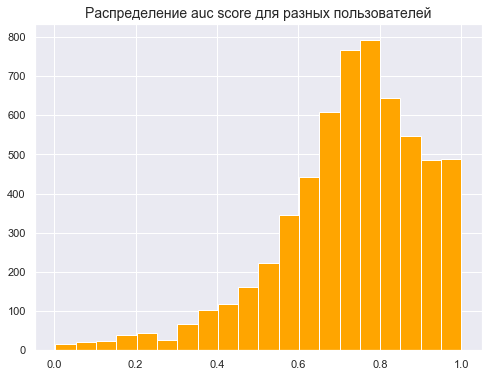

In [139]:
#auc_values_df.to_pickle('lightfm_auc_values.pkl')
auc_values_df = pd.read_pickle('lightfm_auc_values.pkl')
auc_values_df.T['40_cmps'].hist(bins=20, color='orange', figsize=(8,6));
plt.title(label='Распределение auc score для разных пользователей', fontsize=14);

In [140]:
auc_values_df.T['40_cmps'].describe().T

count    5962.000000
mean        0.726743
std         0.178214
min         0.003115
25%         0.636447
50%         0.749327
75%         0.853230
max         1.000000
Name: 40_cmps, dtype: float64

<div class='alert alert-block alert-warning'>
    <p>Примем за оптимальное количество компонент <b>40</b></p>
    <p>Но отметим, что само по себе среднее по пользователям значение <b>$auc=0.727$</b> говорит о низком качестве модели.</p>
    <p>Для 75% пользователей значение auc меньше, чем <b>$0.85$</b>.</p>
</div>

#### Кросс-валидация для оценки качества предсказания неявных рейтингов моделью LightFM

In [141]:
#lightfm_basic_model = LightFM(no_components=40, loss='warp')
#metrics_cv = {'avg_auc' : []}
#for i in range(5):
#    # получаем тренировочную матрицу и индексы тестовой выборки
#    train_data, test_data, test_user_ids, test_item_ids = lightfm_train_test_split(lightfm_data, test_percentage=0.2, random_state=1812+i)    
#    # составляем массив тестовых значений
#    test_ratings = [lightfm_data[row,col] for row,col in zip(test_user_ids, test_item_ids)]
#    # обучаем модель
#    print(f'Итерация {i+1}: обучение', end=', ')
#    lightfm_basic_model.fit(train_data, epochs=10, num_threads=7, verbose=False)
#    print('оценка метрик', end=', ')
#    # вычисляем метрики качества предсказания    
#    auc = auc_score(lightfm_basic_model, test_data)
#    print('сохранение результатов.')
#    metrics_cv['avg_auc'].append(auc.mean())
#
#metrics_cv_df = pd.DataFrame.from_dict(metrics_cv)

In [142]:
#metrics_cv_df.to_pickle('lightfm_cv_results.pkl')
metrics_cv_df = pd.read_pickle('lightfm_cv_results.pkl')
metrics_cv_df.style.highlight_max(axis=None, color='orange')

,avg_auc
0,0.727487
1,0.724186
2,0.721321
3,0.725088
4,0.724605


In [143]:
metrics_cv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_auc,5.0,0.724538,0.002207,0.721321,0.724186,0.724605,0.725088,0.727487


#### Получение рекомендации для конкретного пользователя.

Обучим модель с оптимальными параметрами и выберем одного из пользователей с самой высокой точностью по тестовой выборке.

In [144]:
train_data, test_data, test_user_ids, test_item_ids = lightfm_train_test_split(lightfm_data, test_percentage=0.2, random_state=2024)

In [145]:
lightfm_recommender = LightFM(no_components=40, loss='warp')
lightfm_recommender.fit(train_data, epochs=10, num_threads=7, verbose=False)

In [146]:
lightfm_auc_sparse = auc_score(lightfm_recommender, test_data, preserve_rows=True)

In [147]:
lightfm_auc_df = pd.DataFrame(data=lightfm_auc_sparse, index = user_book_df.index)
lightfm_auc_df.columns=['auc']
lightfm_auc_df['count'] = user_book_df.astype(bool).sum(axis=1)

In [148]:
lightfm_sorted_auc = lightfm_auc_df.sort_values(by=['count', 'auc'], ascending=False)
lightfm_sorted_auc[:25].style.highlight_max(color='orange')

,auc,count
user_id,,
11676,0.544542,2033
98391,0.805074,396
16795,0.822641,364
153662,0.726668,361
95359,0.966867,302
114368,0.513525,295
104636,0.54897,288
158295,0.5,232
123883,0.746011,218


Посмотрим на распределение количества отзывов и оценки auc. Отбросим пользователей, не поставивших ни одной оценки - для них auc устанавливается равным 0.5.

In [149]:
from scipy import stats

C:\Users\Supervisor\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


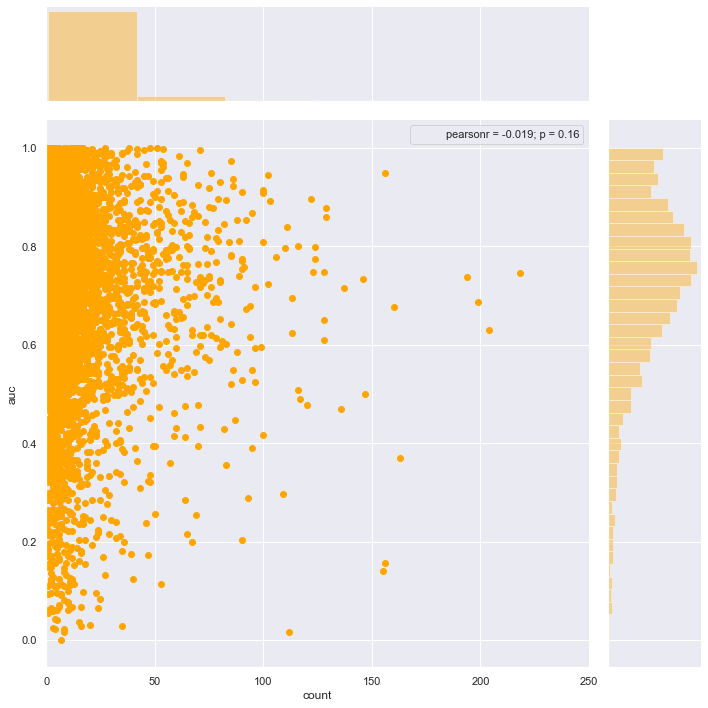

In [150]:
g = sns.jointplot(data=lightfm_sorted_auc[(lightfm_sorted_auc['auc'] != 0.5) & ((lightfm_sorted_auc['count'] > 0))], x='count', y='auc', height=10, kind='scatter', xlim=(0,250), color='orange');
g = g.annotate(stats.pearsonr)

Корреляции между количеством отзывов и точностью прогноза не наблюдается.</br>
Выбираем пользователя с id '95359' - для него auc близко к 1, а количество оценок 302.

In [171]:
def get_ligtfm_user_recommendations(model, interactions_dataframe, user_id, item_id_list, n_items=5):
    
    df_columns = interactions_dataframe.columns.tolist()
    df_index = interactions_dataframe.T.columns.tolist()
    
    user_raw_id = df_index.index(user_id)
    
    book_id_to_raw_id = {key:value for value, key in enumerate(df_columns)}
    book_raw_id_to_id = {key:value for key, value in enumerate(df_columns)}
    
    item_raw_id_list = [book_id_to_raw_id[item_id] for item_id in item_id_list]
    
    sorted_user_ratings = interactions_dataframe.loc[user_id].sort_values(ascending=False)
    
    existing_item_ratings = list(zip(sorted_user_ratings.index.tolist(), sorted_user_ratings.to_list()))
    known_items = {key:value for key,value in existing_item_ratings[:n_items]}
    
    predicted_item_ratings = list(zip(item_id_list, model.predict(user_raw_id, item_raw_id_list)))
    predicted_item_ratings.sort(key=(lambda x: x[1]), reverse=True)
    predicted_items = {key:value for key,value in predicted_item_ratings[:n_items]}
    
    return known_items, predicted_items

#### Определяем топ 15 известных и предсказанных рейтингов для нашего пользователя

In [174]:
selected_user_id = '95359'

In [175]:
known_items, predicted_items = get_ligtfm_user_recommendations(model=lightfm_recommender, interactions_dataframe=user_book_df, user_id=selected_user_id, item_id_list=book_raw_ids, n_items=15)

#### Известные предпотчения конкретного пользователя:

In [176]:
book_info_df[book_info_df['book_id'].isin(known_items.keys())]

,book_id,title,author,year,publisher
581,0449907481,A Thousand Acres (Ballantine Reader's Circle),JANE SMILEY,1992.0,Ballantine Books
914,0345391802,The Hitchhiker's Guide to the Galaxy,Douglas Adams,1995.0,Ballantine Books
1500,0385491050,Surfacing,MARGARET ATWOOD,1998.0,Anchor
1511,0312243022,The Hours : A Novel,Michael Cunningham,2000.0,Picador
1908,0385492081,Into Thin Air : A Personal Account of the Mt. ...,JON KRAKAUER,1998.0,Anchor
2104,0451524934,1984,George Orwell,1990.0,Signet Book
3078,1559029838,Call of the Wild,Jack London,0.0,Selldowns/no More Orders
5283,0142001430,Year of Wonders,Geraldine Brooks,2002.0,Penguin Books
5506,043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003.0,Scholastic
6843,0440998050,A Wrinkle in Time,Madeleine L'Engle,1976.0,Laure Leaf


#### Выбираем из предсказанных те, которые пользователь ещё не оценил...

In [177]:
recommended_ratings = []
for item_id in predicted_items.keys():
    if item_id not in known_items:
        recommended_ratings.append(item_id)

#### Список рекомендаций:

In [178]:
book_info_df[book_info_df['book_id'].isin(recommended_ratings)]

,book_id,title,author,year,publisher
565,0385721420,Three Junes,JULIA GLASS,2003.0,Anchor
602,0020442408,Prince Caspian,C. S. Lewis,1970.0,MacMillan Publishing Company.
1105,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial
1931,0345425707,A Cup of Tea (Ballantine Reader's Circle),Amy Ephron,1998.0,Ballantine Books
2943,0020532105,CRY THE BELOVED COUNTRY (Scribner Classic),Alan Paton,1987.0,Scribner
2948,0312305060,The Hours: A Novel,Michael Cunningham,2002.0,Picador
3232,0007154615,Unless : A Novel,Carol Shields,2003.0,Perennial
4709,0060931809,The Map That Changed the World : William Smith...,Simon Winchester,2002.0,Perennial
5088,031286504X,I Am Legend,Richard Matheson,1997.0,Orb Books
5258,0140049975,East of Eden,John Steinbeck,1984.0,Penguin Books


#### Сравним с рекомендациями модели surprise...

In [179]:
known_items, predicted_items = get_surprise_user_recommendations(svd_model, surprise_data, user_id=selected_user_id, item_id_list=book_raw_ids, n_items=15)

In [180]:
recommended_ratings = []
for item_id in predicted_items.keys():
    if item_id not in known_items:
        recommended_ratings.append(item_id)

In [181]:
book_info_df[book_info_df['book_id'].isin(recommended_ratings)]

,book_id,title,author,year,publisher
1985,0449212602,The Handmaid's Tale,Margaret Atwood,1989.0,Fawcett Books
2232,0812550706,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1994.0,Tor Books
2783,0452269571,Bastard Out of Carolina,Dorothy Allison,1993.0,Plume Books
2802,0060392452,Stupid White Men ...and Other Sorry Excuses fo...,Michael Moore,2002.0,Regan Books
3171,0380002930,Watership Down,Richard Adams,1976.0,Avon
4291,0375703764,House of Leaves,Mark Z. Danielewski,2000.0,Pantheon Books
6317,0689710682,Mrs. Frisby and the Rats of Nimh,Robert C. O'Brien,1986.0,Aladdin
6820,1853260150,Picture of Dorian Gray (Wordsworth Classics),Oscar Wilde,1997.0,NTC/Contemporary Publishing Company
8083,0380709562,"Ramona Quimby, Age 8 (Avon Camelot Books (Pape...",Beverly Cleary,1992.0,HarperTrophy
18719,0440404193,"Are You There God? It's Me, Margaret",JUDY BLUME,1971.0,Yearling
